variables: k, epsilon, n_iter, privacy budget

- epsilon = 0.5,1,2,5
- k depends on dataset, can try around 10 values close to true number of groups. 
- n_iter = 3,4,5,6,7,8 maybe? 

Privacy Budget Choices
- Uniform
- Dichotomy
- Series Sum

Most basic analysis required: for epsilon=1 vary the number of centers, number of iterations and try different privacy budget allocation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from lloyd import PrivacyBudget, dplloyd
from evaluation_utils import kmeans_loss
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

master_rng = np.random.default_rng(42)
print(plt.style.available)
plt.style.use('seaborn-v0_8') 

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


1.0
0.9090909090909091
0.9990234375
1.0


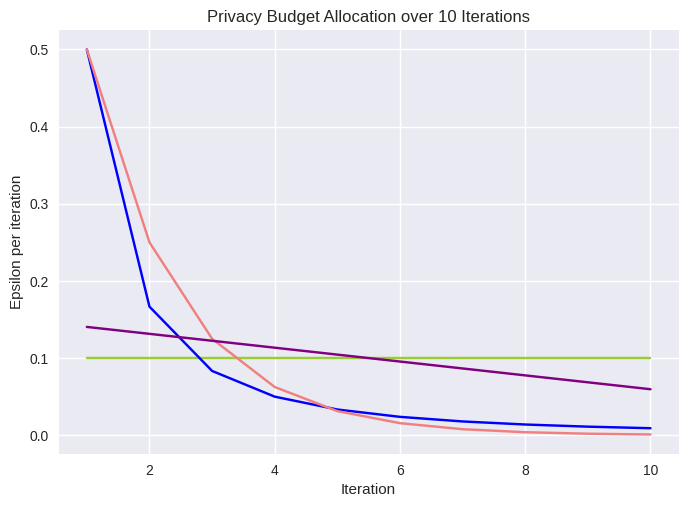

In [ ]:
# Privacy Budgets 

uniform_budget = PrivacyBudget(epsilon=1, method="uniform", total_iter=10)
series_sum_budget = PrivacyBudget(epsilon=1, method="series sum", total_iter=10)
dichotomy_budget = PrivacyBudget(epsilon=1, method="dichotomy", total_iter=10)
arithmetic_budget = PrivacyBudget(epsilon=1, method="arithmetic", total_iter=10, k=2, d=9, N=30000) # dataset values are that of forest

uniform_eps = [uniform_budget.getEpsilon(t) for t in range(1,11)]
series_sum_eps = [series_sum_budget.getEpsilon(t) for t in range(1,11)]
dichotomy_eps = [dichotomy_budget.getEpsilon(t) for t in range(1,11)]
arithmetic_eps = [arithmetic_budget.getEpsilon(t) for t in range(1,11)]

ts = list(range(1,11))

plt.plot(ts, uniform_eps, c="yellowgreen")
plt.plot(ts, series_sum_eps, c="blue")
plt.plot(ts, dichotomy_eps, c="lightcoral")
plt.plot(ts, arithmetic_eps, c="purple")
plt.legend(["Uniform", "Series Sum", "Dichotomy", "Arithmetic"])

plt.xlabel("Iteration")
plt.ylabel("Epsilon per iteration")
plt.title("Privacy Budget Allocation over 10 Iterations")


print(sum(uniform_eps))
print(sum(series_sum_eps))
print(sum(dichotomy_eps))
print(sum(arithmetic_eps))


### Initial Experimentation: How many iterations is preferable? 

(4, 3, 2)


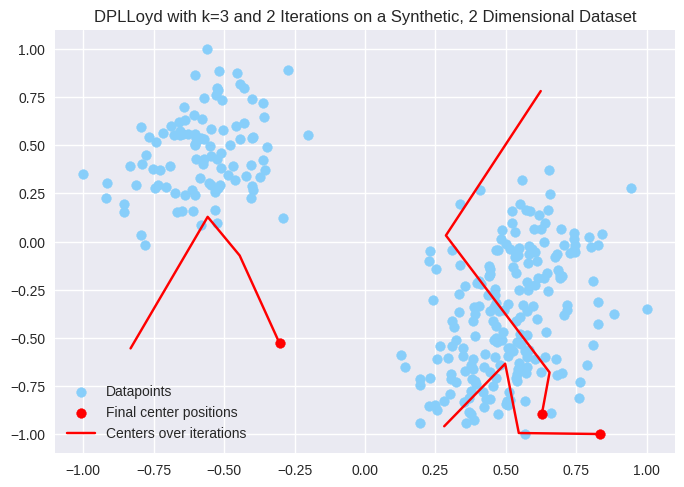

Loss:  0.6362852320082268


In [3]:
data = np.load("datasets/synthetic-gaussian.npy")
p = PrivacyBudget(epsilon=1, method="series sum", total_iter=2)
centers = np.array(dplloyd(k=3, X=data, n_iter=3, priv=p, seed=123, return_steps=True))

print(centers.shape)
#non_private_centers = KMeans(n_clusters=3).fit(data).cluster_centers_

plt.style.use('seaborn-v0_8') 
fig = plt.figure()
ax = plt.axes()
ax.set_title("DPLLoyd with k=3 and 2 Iterations on a Synthetic, 2 Dimensional Dataset")
ax.scatter(data[:,0], data[:,1], c='lightskyblue')
#ax.scatter(non_private_centers[:,0], non_private_centers[:,1], c='red')
ax.scatter(centers[-1,:,0], centers[-1,:,1], c="red")
ax.plot(centers[:,:,0], centers[:,:,1], c="red")
ax.legend(["Datapoints","Final center positions","Centers over iterations"], loc='lower left')

plt.show()

print("Loss: ", kmeans_loss(centers[-1,:,:], data))

(6, 3, 2)


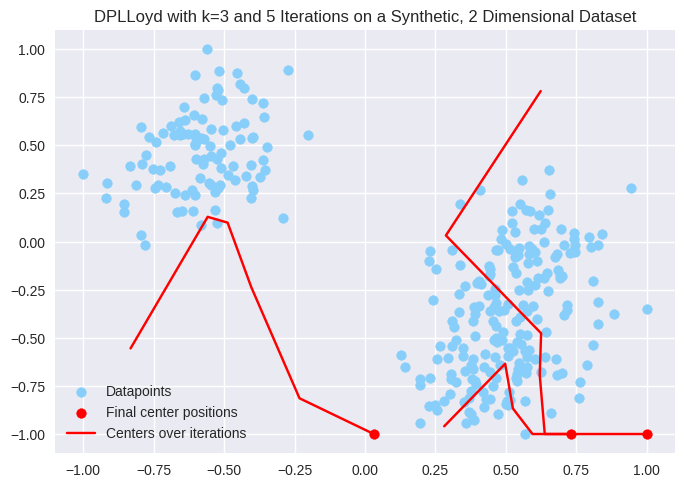

In [4]:
# what happens when the number of iterations is too hight?

p = PrivacyBudget(epsilon=1, method="dichotomy", total_iter=5)
centers = np.array(dplloyd(k=3, X=data, n_iter=5, priv=p, seed=123, return_steps=True))

print(centers.shape)
#non_private_centers = KMeans(n_clusters=3).fit(data).cluster_centers_

fig = plt.figure()
ax = plt.axes()
ax.set_title("DPLLoyd with k=3 and 5 Iterations on a Synthetic, 2 Dimensional Dataset")
ax.scatter(data[:,0], data[:,1], c='lightskyblue')
#ax.scatter(non_private_centers[:,0], non_private_centers[:,1], c='red')
ax.scatter(centers[-1,:,0], centers[-1,:,1], c="red")
ax.plot(centers[:,:,0], centers[:,:,1], c="red")
ax.legend(["Datapoints","Final center positions","Centers over iterations"], loc='lower left')

plt.show()

(3, 6, 2)


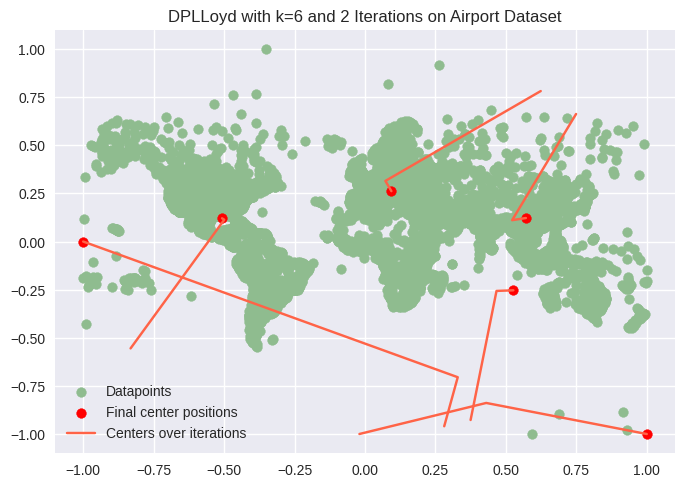

Loss:  0.055065397443404974


In [5]:
data = np.load("datasets/airports.npy")

p = PrivacyBudget(epsilon=1, method="uniform", total_iter=2)
centers = np.array(dplloyd(k=6, X=data, n_iter=2, priv=p, seed=43242, return_steps=True))

print(centers.shape)
#non_private_centers = KMeans(n_clusters=3).fit(data).cluster_centers_

fig = plt.figure()
ax = plt.axes()
ax.set_title("DPLLoyd with k=6 and 2 Iterations on Airport Dataset")
ax.scatter(data[:,0], data[:,1], c='darkseagreen')
#ax.scatter(non_private_centers[:,0], non_private_centers[:,1], c='red')
ax.scatter(centers[-1,:,0], centers[-1,:,1], c="red")
ax.plot(centers[:,:,0], centers[:,:,1], c="tomato")
ax.legend(["Datapoints","Final center positions","Centers over iterations"], loc='lower left')

plt.show()

print("Loss: ", kmeans_loss(centers[-1,:,:], data))

Comments:

If the initial centers are in a fairly good position, doing one or two iterations produces reasonable results with uniform privacy budget. 

If epsilon is larger, we can afford more iterations. 

If the number of points is larger, we can afford more iterations. 

In [13]:
def dplloyd_experiment(X, k, epsilon, method, iterations, trials=20, output=False):
    if method == "arithmetic":
        d = X.shape[1]
        N = X.shape[0]
        p = PrivacyBudget(epsilon=epsilon, method=method, total_iter=iterations, k=k, d=d, N=N)
    else:
        p = PrivacyBudget(epsilon=epsilon, method=method, total_iter=iterations)
    # do 20 randomised trials
    base_seed = master_rng.integers(low=0, high=100000)
    trials = [dplloyd(k=k, X=X, n_iter=iterations, priv=p, seed=base_seed + x) for x in range(20)]
    losses = [kmeans_loss(centers, X) for centers in trials]
    avg_loss = np.mean(losses)
    if output: 
        print(f"base seed={base_seed}, average loss={avg_loss}")
    return avg_loss

### Small Synthetic Gaussian 

In [7]:
data = np.load("datasets/synthetic-gaussian.npy")

# lets vary number of iterations for e=1, k=4 and series sum privacy budget

print("Series Sum:")
series_sum_results = np.empty(10)
for total_iterations in range(1,11):
    series_sum_results[total_iterations-1]=dplloyd_experiment(X=data, k=3, epsilon=1, method="series sum", iterations=total_iterations, trials=50)

# dichotomy privacy budget

print("Dichotomy:")
dichotomy_results = np.empty(10)
for total_iterations in range(1,11):
    dichotomy_results[total_iterations-1]=dplloyd_experiment(X=data, k=3, epsilon=1, method="dichotomy", iterations=total_iterations, trials=50)

# uniform privacy budget

print("Uniform: ")
uniform_results = np.empty(10)
for total_iterations in range(1,11):
    uniform_results[total_iterations-1]=dplloyd_experiment(X=data, k=3, epsilon=1, method="uniform", iterations=total_iterations, trials=50)


Series Sum:
Dichotomy:
Uniform: 


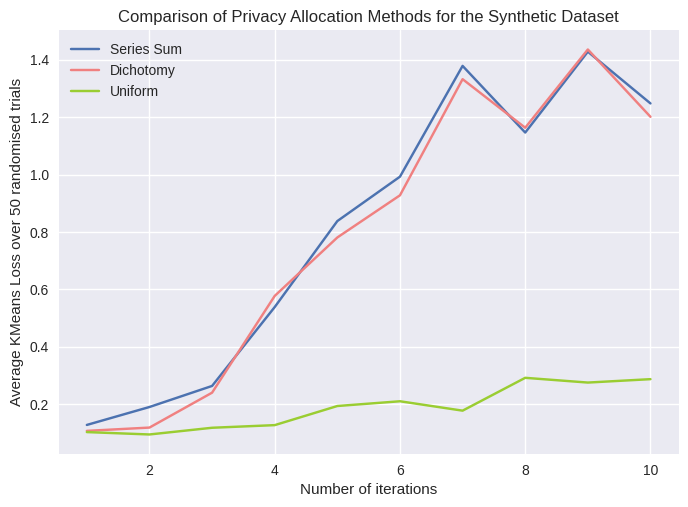

In [8]:
x = list(range(1,11))
plt.plot(x, series_sum_results)
plt.plot(x, dichotomy_results, c="lightcoral")
plt.plot(x, uniform_results, c="yellowgreen")
plt.title("Comparison of Privacy Allocation Methods for the Synthetic Dataset")
plt.xlabel("Number of iterations")
plt.ylabel("Average KMeans Loss over 50 randomised trials")
plt.legend(["Series Sum", "Dichotomy", "Uniform"])

Series Sum:
Dichotomy:
Uniform: 


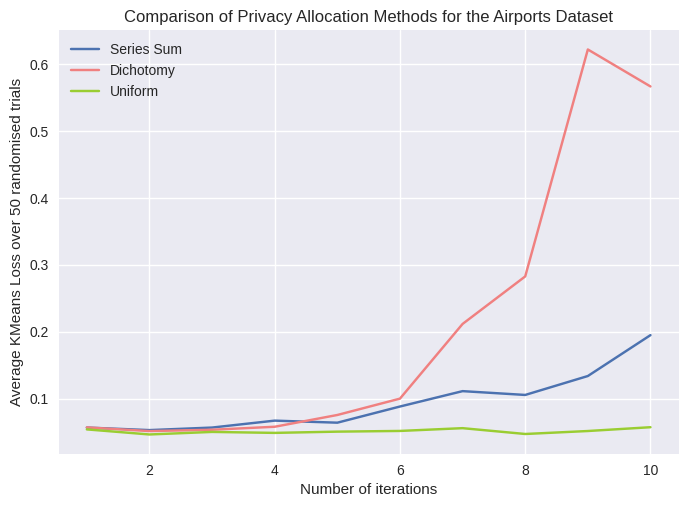

In [9]:
data = np.load("datasets/airports.npy")


print("Series Sum:")
series_sum_results = np.empty(10)
for total_iterations in range(1,11):
    series_sum_results[total_iterations-1]=dplloyd_experiment(X=data, k=6, epsilon=1, method="series sum", iterations=total_iterations, trials=20)

# dichotomy privacy budget

print("Dichotomy:")
dichotomy_results = np.empty(10)
for total_iterations in range(1,11):
    dichotomy_results[total_iterations-1]=dplloyd_experiment(X=data, k=6, epsilon=1, method="dichotomy", iterations=total_iterations, trials=20)

# uniform privacy budget

print("Uniform: ")
uniform_results = np.empty(10)
for total_iterations in range(1,11):
    uniform_results[total_iterations-1]=dplloyd_experiment(X=data, k=6, epsilon=1, method="uniform", iterations=total_iterations, trials=20)

x = list(range(1,11))
plt.plot(x, series_sum_results)
plt.plot(x, dichotomy_results, c="lightcoral")
plt.plot(x, uniform_results, c="yellowgreen")
plt.title("Comparison of Privacy Allocation Methods for the Airports Dataset")
plt.xlabel("Number of iterations")
plt.ylabel("Average KMeans Loss over 50 randomised trials")
plt.legend(["Series Sum", "Dichotomy", "Uniform"])

In [20]:
arithmetic_results = np.empty(10)
for total_iterations in range(2,11):
    arithmetic_results[total_iterations-1]=dplloyd_experiment(X=data, k=6, epsilon=1, method="arithmetic", iterations=total_iterations, trials=20)


Privacy budget too small for arithmetic progression approach, using uniform. 
 Minimum epsilon calculated as  0.20177305419509864
Privacy budget too small for arithmetic progression approach, using uniform. 
 Minimum epsilon calculated as  0.20177305419509864
Privacy budget too small for arithmetic progression approach, using uniform. 
 Minimum epsilon calculated as  0.20177305419509864
Privacy budget too small for arithmetic progression approach, using uniform. 
 Minimum epsilon calculated as  0.20177305419509864
Privacy budget too small for arithmetic progression approach, using uniform. 
 Minimum epsilon calculated as  0.20177305419509864
Privacy budget too small for arithmetic progression approach, using uniform. 
 Minimum epsilon calculated as  0.20177305419509864


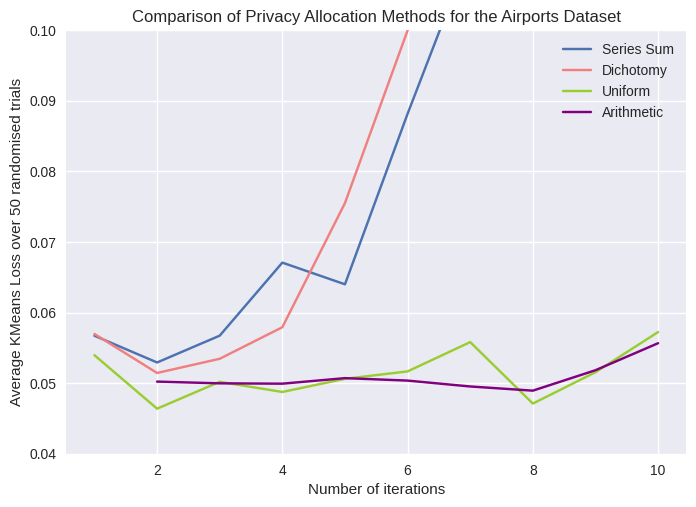

In [23]:
x = list(range(1,11))
plt.plot(x, series_sum_results)
plt.plot(x, dichotomy_results, c="lightcoral")
plt.plot(x, uniform_results, c="yellowgreen")
plt.plot(list(range(2,11)), arithmetic_results[1:], c="purple")
plt.ylim((0.04,0.1))
plt.title("Comparison of Privacy Allocation Methods for the Airports Dataset")
plt.xlabel("Number of iterations")
plt.ylabel("Average KMeans Loss over 50 randomised trials")
plt.legend(["Series Sum", "Dichotomy", "Uniform", "Arithmetic"])

In [ ]:
# Varying K 

for k in range(1, 9):
    p = PrivacyBudget(epsilon=1, method="uniform", total_iter=2)

    base_seed = master_rng.integers(low=0, high=100000)
    trials = [dplloyd(k=k, X=data, n_iter=2, priv=p, seed=base_seed + x) for x in range(20)]
    losses = [kmeans_loss(centers, data) for centers in trials]

    print(f"k={k}, average loss={np.mean(losses)}")



k=2, average loss=0.16766085284810275
k=3, average loss=0.1867147234541628
k=4, average loss=0.1891462429604989
k=5, average loss=0.14031014006244838
k=6, average loss=0.12118518809736947
k=7, average loss=0.12584013107050201
k=8, average loss=0.11935861314845211


### Iris Dataset

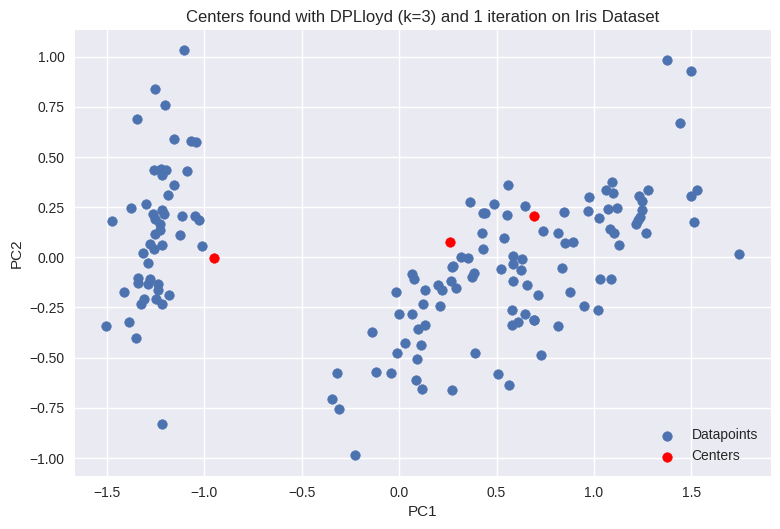

Loss (in 4 dimensions):  0.4366681657389569


In [65]:
iris = np.load("datasets/iris.npy")
iris.shape

# for data visualisation
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
iris_2d = pca.fit_transform(iris)
plt.scatter(iris_2d[:,0], iris_2d[:,1])

non_private_centers = KMeans(n_clusters=3).fit(iris).cluster_centers_
non_private_centers_2d = pca.transform(non_private_centers)
#plt.scatter(non_private_centers_2d[:,0], non_private_centers_2d[:,1], c="magenta")

p = PrivacyBudget(epsilon=1, method="uniform", total_iter=1)
centers = np.array(dplloyd(k=3, X=iris, n_iter=1, priv=p, seed=6434, return_steps=False))
centers_2d = pca.transform(centers)
plt.scatter(centers_2d[:,0], centers_2d[:,1], c="red")
plt.title("Centers found with DPLloyd (k=3) and 1 iteration on Iris Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Datapoints", "Centers"])
plt.show()

print("Loss (in 4 dimensions): ", kmeans_loss(centers, iris))

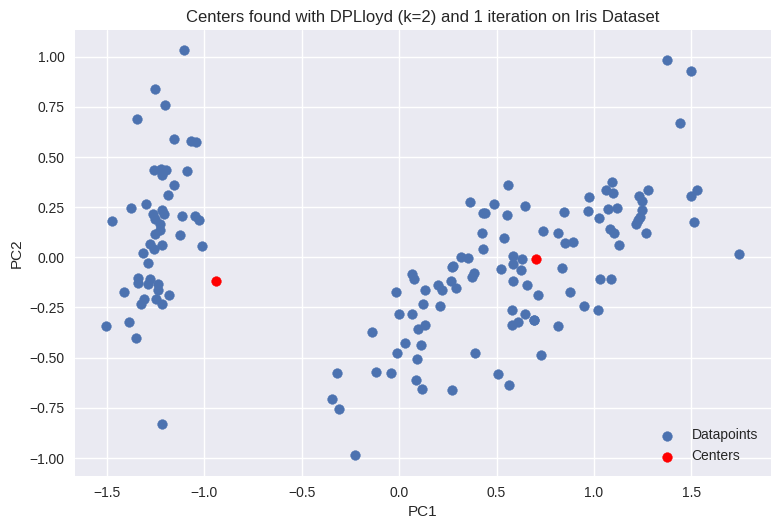

Loss (in 4 dimensions):  0.36520047785024834


In [67]:
plt.scatter(iris_2d[:,0], iris_2d[:,1])

p = PrivacyBudget(epsilon=1, method="uniform", total_iter=1)
centers = np.array(dplloyd(k=2, X=iris, n_iter=1, priv=p, seed=13123, return_steps=False))
centers_2d = pca.transform(centers)
plt.scatter(centers_2d[:,0], centers_2d[:,1], c="red")
plt.title("Centers found with DPLloyd (k=2) and 1 iteration on Iris Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Datapoints", "Centers"])
plt.show()

print("Loss (in 4 dimensions): ", kmeans_loss(centers, iris))

Series Sum:
Dichotomy:
Uniform: 


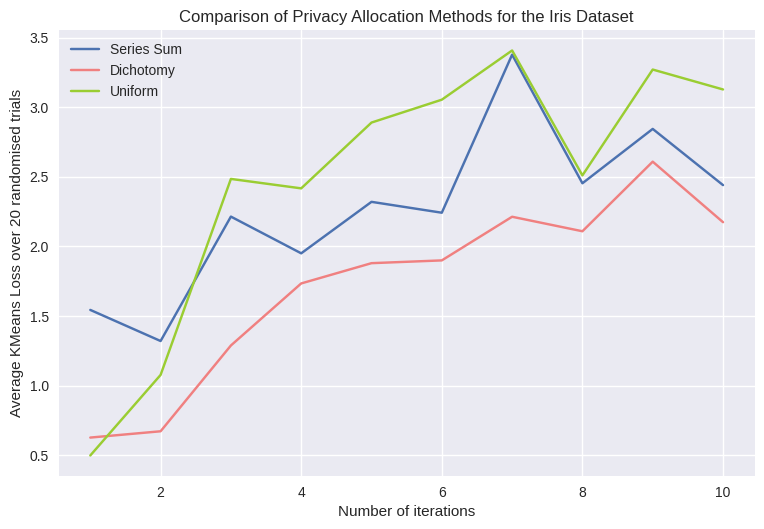

In [59]:
data = np.load("datasets/iris.npy")


print("Series Sum:")
series_sum_results = np.empty(10)
for total_iterations in range(1,11):
    series_sum_results[total_iterations-1]=dplloyd_experiment(X=data, k=3, epsilon=1, method="series sum", iterations=total_iterations, trials=20)

# dichotomy privacy budget

print("Dichotomy:")
dichotomy_results = np.empty(10)
for total_iterations in range(1,11):
    dichotomy_results[total_iterations-1]=dplloyd_experiment(X=data, k=3, epsilon=1, method="dichotomy", iterations=total_iterations, trials=20)

# uniform privacy budget

print("Uniform: ")
uniform_results = np.empty(10)
for total_iterations in range(1,11):
    uniform_results[total_iterations-1]=dplloyd_experiment(X=data, k=3, epsilon=1, method="uniform", iterations=total_iterations, trials=20)

x = list(range(1,11))
plt.plot(x, series_sum_results)
plt.plot(x, dichotomy_results, c="lightcoral")
plt.plot(x, uniform_results, c="yellowgreen")
plt.title("Comparison of Privacy Allocation Methods for the Iris Dataset")
plt.xlabel("Number of iterations")
plt.ylabel("Average KMeans Loss over 20 randomised trials")
plt.legend(["Series Sum", "Dichotomy", "Uniform"])

Best method appears to be uniform with 1 iteration, followed by dichotomy with 1 iteration and then dichotomy with 2 iterations 

In [25]:
# varying epsilon for top 3 methods

for epsilon in [0.5,1,2,5,10]:
    print("Epsilon = ", epsilon)
    print("Uniform average loss = ", dplloyd_experiment(iris, 3, epsilon, "uniform", 1, trials=50))
    print("Dichotomy 1 average loss = ", dplloyd_experiment(iris, 3, epsilon, "dichotomy", 1, trials=50))
    print("Dichotomy 2 average loss = ", dplloyd_experiment(iris, 3, epsilon, "dichotomy", 2, trials = 50))


Epsilon =  0.5
Uniform average loss =  0.9950763552307453
Dichotomy 1 average loss =  1.3616685656547483
Dichotomy 2 average loss =  1.026086899965496
Epsilon =  1
Uniform average loss =  0.526062197445029
Dichotomy 1 average loss =  0.6514200545468517
Dichotomy 2 average loss =  0.7127391284916699
Epsilon =  2
Uniform average loss =  0.3838034274199856
Dichotomy 1 average loss =  0.45154395562795946
Dichotomy 2 average loss =  0.47144570754916704
Epsilon =  5
Uniform average loss =  0.3385228535328868
Dichotomy 1 average loss =  0.40092540320785225
Dichotomy 2 average loss =  0.35394364620303875
Epsilon =  10
Uniform average loss =  0.3290090032460913
Dichotomy 1 average loss =  0.3497949972145712
Dichotomy 2 average loss =  0.31846095181056244


^ Plateaus after epsilon = 2 

### Large Synthetic

(10000, 100)
KMeans loss:  3.9718238341552774
[[-0.39132901 -0.3319128  -0.49716378  0.28743404  0.03699726  0.07013302
   0.21622832  0.02413071 -0.08978463 -0.22173881  0.49855112  0.38331304
   0.36121127  0.4192881   0.48476264 -0.08176833 -0.16889174 -0.48473364
   0.08401371  0.35570616 -0.22243807  0.17575851 -0.28816998  0.35536765
  -0.49140925 -0.44451758 -0.39370349 -0.13574979  0.07268442  0.19166379
  -0.31913626 -0.39851741 -0.3555903  -0.08929465 -0.12185373  0.11993027
  -0.07023357 -0.44998096  0.21584818 -0.30608416 -0.38396292 -0.18015136
   0.08364242 -0.41039007  0.08452763 -0.32918007 -0.03021435  0.21294598
   0.48340305  0.22037724 -0.13962232 -0.22742874 -0.37404027 -0.26920855
   0.38545448 -0.04627746 -0.17609118  0.30355716 -0.23611652  0.05854557
   0.24978736 -0.37868856 -0.50374202 -0.43294911  0.59862787 -0.34050421
  -0.10971099 -0.45865361 -0.01721452 -0.06291715 -0.27324455 -0.11640112
  -0.08737155  0.50560301 -0.44177177  0.33856322 -0.14779715 -0.4

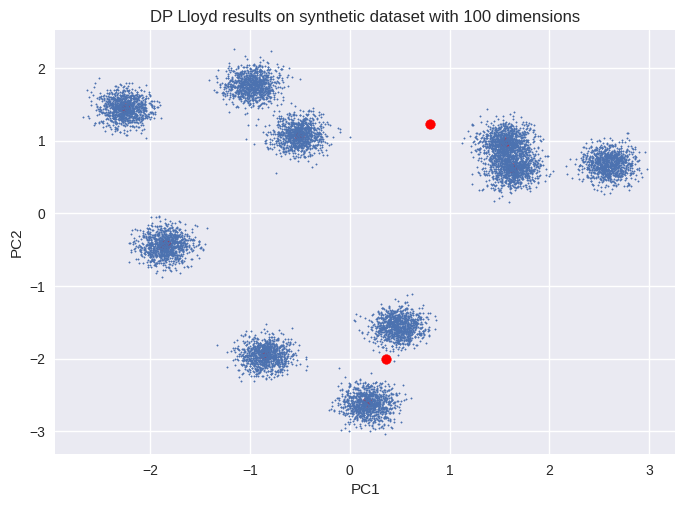

In [ ]:
large = np.load("datasets/large-synthetic.npy")
print(large.shape)

large_pca = PCA(n_components=2)
large_2d = large_pca.fit_transform(large)

p = PrivacyBudget(epsilon=150, delta=None, method="arithmetic", total_iter=2, k=10, d=large.shape[1], N=large.shape[0])
centers = dplloyd(k=10, X=large, n_iter=2, priv=p, seed=25323, return_steps=False)

centers_2d = large_pca.transform(centers)

plt.scatter(centers_2d[:,0], centers_2d[:,1], c="red")
plt.scatter(large_2d[:,0], large_2d[:,1], s=1)
plt.title("DP Lloyd results on synthetic dataset with 100 dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2")
print("KMeans loss: ", kmeans_loss(centers, large))
print(centers.shape)

In [72]:
for iters in range(1,10):
    dplloyd_experiment(X=large, k=10, epsilon=1, method="dichotomy", iterations=iters, trials=1, output=True)

base seed=17677, average loss=23.08997243285784
base seed=46320, average loss=15.980121449993842
base seed=85661, average loss=16.29819101230059
base seed=1952, average loss=16.99706947316492
base seed=75851, average loss=17.531944690306904
base seed=49276, average loss=18.653841650739743


KeyboardInterrupt: 

### Concrete

(1030, 8)


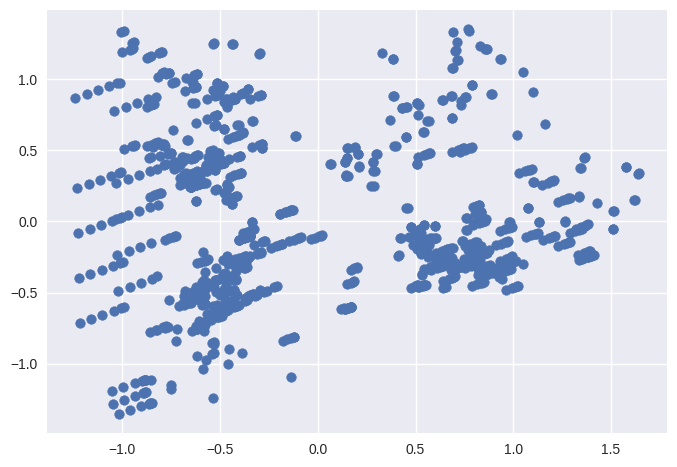

In [38]:
concrete = np.load("datasets/concrete.npy")
print(concrete.shape)

concrete_pca = PCA(n_components=2)
concrete_2d = concrete_pca.fit_transform(concrete)

plt.scatter(concrete_2d[:,0], concrete_2d[:,1])


From a visual inspection I would start with k=3. 

(4, 3, 8)
(1030, 8)


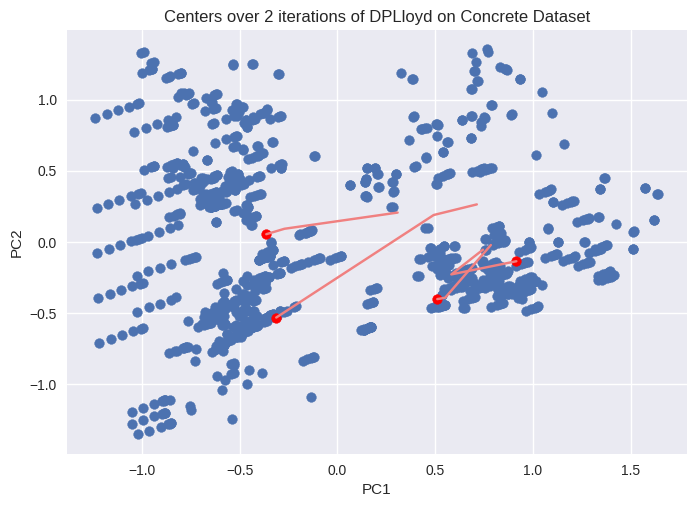

In [41]:
p = PrivacyBudget(epsilon=1, method="uniform", total_iter=2)
centers = np.array(dplloyd(k=4, X=concrete, n_iter=2, priv=p, seed=535353, return_steps=True))
reshaped_centers = centers.transpose(1,0,2)

print(reshaped_centers.shape)
print(concrete.shape)

c = [reshaped_centers[n,:,:] for n in range(4)]
centers_2d = [concrete_pca.transform(d) for d in c]

#non_private_centers = KMeans(n_clusters=5).fit(concrete).cluster_centers_
#non_private_centers_2d = concrete_pca.transform(non_private_centers)

plt.scatter(concrete_2d[:,0], concrete_2d[:,1])
#plt.scatter(non_private_centers_2d[:,0], non_private_centers_2d[:,1], c="yellow")
for x in centers_2d:
    plt.plot(x[:,0], x[:,1], c="lightcoral")
    plt.scatter(x[-1,0], x[-1,1], c="red")

plt.title("Centers over 2 iterations of DPLloyd on Concrete Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Series Sum:
Dichotomy:
Uniform: 


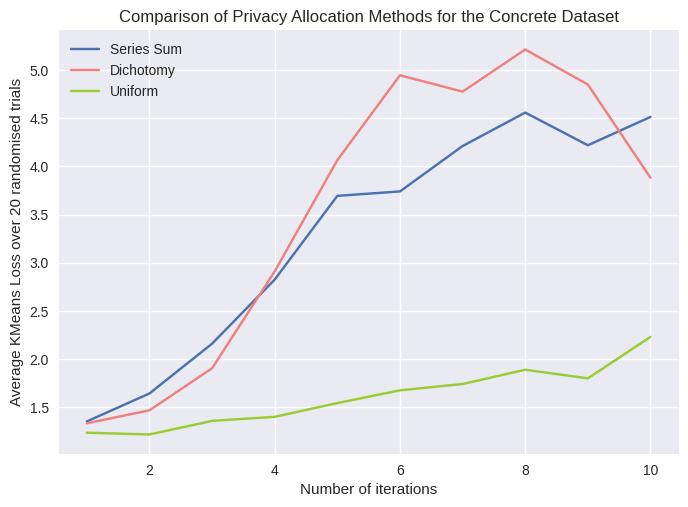

In [40]:
data = np.load("datasets/concrete.npy")


print("Series Sum:")
series_sum_results = np.empty(10)
for total_iterations in range(1,11):
    series_sum_results[total_iterations-1]=dplloyd_experiment(X=data, k=4, epsilon=1, method="series sum", iterations=total_iterations, trials=20)

# dichotomy privacy budget

print("Dichotomy:")
dichotomy_results = np.empty(10)
for total_iterations in range(1,11):
    dichotomy_results[total_iterations-1]=dplloyd_experiment(X=data, k=4, epsilon=1, method="dichotomy", iterations=total_iterations, trials=20)

# uniform privacy budget

print("Uniform: ")
uniform_results = np.empty(10)
for total_iterations in range(1,11):
    uniform_results[total_iterations-1]=dplloyd_experiment(X=data, k=4, epsilon=1, method="uniform", iterations=total_iterations, trials=20)

x = list(range(1,11))
plt.plot(x, series_sum_results)
plt.plot(x, dichotomy_results, c="lightcoral")
plt.plot(x, uniform_results, c="yellowgreen")
plt.title("Comparison of Privacy Allocation Methods for the Concrete Dataset")
plt.xlabel("Number of iterations")
plt.ylabel("Average KMeans Loss over 20 randomised trials")
plt.legend(["Series Sum", "Dichotomy", "Uniform"])

In [89]:
for k in range(3,7):
    print("k = ",k)
    dplloyd_experiment(concrete, k, 1, "dichotomy", 2, trials=50, output=True)

k =  3
base seed=66329, average loss=1.4350218719703494
k =  4
base seed=43209, average loss=1.4192951709346822
k =  5
base seed=30866, average loss=1.3685931404537912
k =  6
base seed=62730, average loss=1.3546532419554835


In [53]:
print("Uniform:")
for total_iterations in range(1,6):
    dplloyd_experiment(concrete, 4, 1, "uniform", total_iterations, 50, output=True)

print("Dichotomy:")
for total_iterations in range(1,6):
    dplloyd_experiment(concrete, 4, 1, "dichotomy", total_iterations, 50, output=True)

print("Series Sum:")
for total_iterations in range(1,6):
    dplloyd_experiment(concrete, 4, 1, "series sum", total_iterations, 50, output=True)

Uniform:
base seed=78156, average loss=1.2600041408337739
base seed=64386, average loss=1.4739685712787136
base seed=40241, average loss=2.020911893029471
base seed=82276, average loss=2.53938085900339
base seed=54542, average loss=3.996060883779711
Dichotomy:
base seed=44341, average loss=1.3523319368987512
base seed=45045, average loss=1.4592551893720123
base seed=22723, average loss=1.57913152030926
base seed=9213, average loss=1.5886243606596637
base seed=55458, average loss=1.699737450360379
Series Sum:
base seed=88788, average loss=1.611654607203884
base seed=6381, average loss=1.6080484525341396
base seed=85829, average loss=1.755602913478525
base seed=82763, average loss=1.7535093427266308
base seed=27675, average loss=2.1441239338228417


In [42]:
forest = np.load("datasets/forest-large.npy")
forest.shape

(581012, 9)

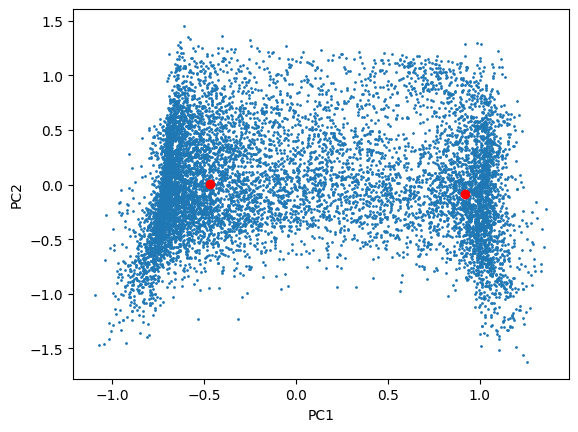

In [20]:
pca = PCA(n_components = 2)
forest_2d = pca.fit_transform(forest)

plt.scatter(forest_2d[:,0], forest_2d[:,1], s=1)
plt.xlabel("PC1")
plt.ylabel("PC2")

p = PrivacyBudget(epsilon=1, method="dichotomy", total_iter=5)
centers = dplloyd(k=2, X=forest, n_iter=5, priv=p, seed=216824)

centers_2d = pca.transform(centers)
plt.scatter(centers_2d[:,0], centers_2d[:,1], c="red")


In [45]:
iterations = [2,3,4,5,6,7,8]
dichotomy = []
uniform = []
series_sum = []
arithmetic = []

for iter in iterations:
    dichotomy.append(dplloyd_experiment(X=forest, k=7, epsilon=1, method="dichotomy", iterations=iter, trials=20))
    uniform.append(dplloyd_experiment(X=forest, k=7, epsilon=1, method="uniform", iterations=iter, trials=20))
    series_sum.append(dplloyd_experiment(X=forest, k=7, epsilon=1, method="series sum", iterations=iter, trials=20))
    arithmetic.append(dplloyd_experiment(forest, k=7, epsilon=1, method="arithmetic", iterations=iter, trials=20))

KeyboardInterrupt: 

In [46]:
print(dichotomy)

[np.float64(0.4050537896648704)]


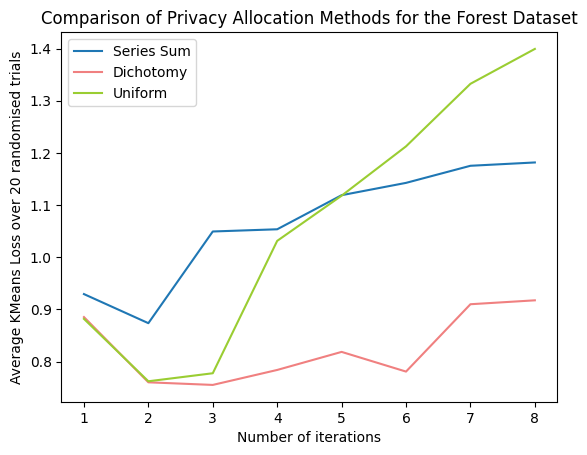

In [16]:
plt.plot(iterations, series_sum)
plt.plot(iterations, dichotomy, c="lightcoral")
plt.plot(iterations, uniform, c="yellowgreen")
plt.title("Comparison of Privacy Allocation Methods for the Forest Dataset")
plt.xlabel("Number of iterations")
plt.ylabel("Average KMeans Loss over 20 randomised trials")
plt.legend(["Series Sum", "Dichotomy", "Uniform"])

In [21]:
dichotomy_k4 = []
uniform_k4 = []
series_sum_k4 = []

# for larger values of k
for iter in iterations:
    dichotomy_k4.append(dplloyd_experiment(X=forest, k=4, epsilon=1, method="dichotomy", iterations=iter, trials=20))
    uniform_k4.append(dplloyd_experiment(X=forest, k=4, epsilon=1, method="uniform", iterations=iter, trials=20))
    series_sum_k4.append(dplloyd_experiment(X=forest, k=4, epsilon=1, method="series sum", iterations=iter, trials=20))

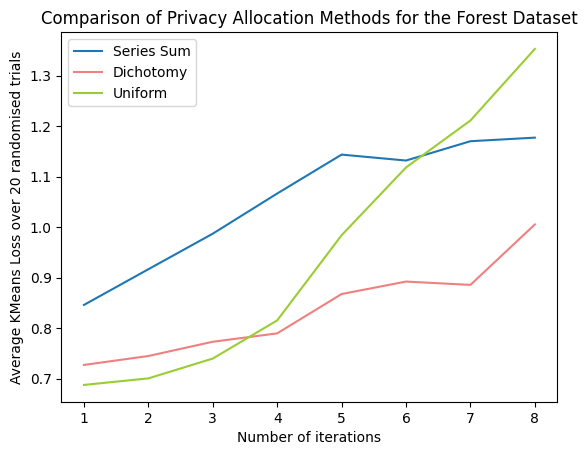

In [22]:
plt.plot(iterations, series_sum_k4)
plt.plot(iterations, dichotomy_k4, c="lightcoral")
plt.plot(iterations, uniform_k4, c="yellowgreen")
plt.title("Comparison of Privacy Allocation Methods for the Forest Dataset")
plt.xlabel("Number of iterations")
plt.ylabel("Average KMeans Loss over 20 randomised trials")
plt.legend(["Series Sum", "Dichotomy", "Uniform"])

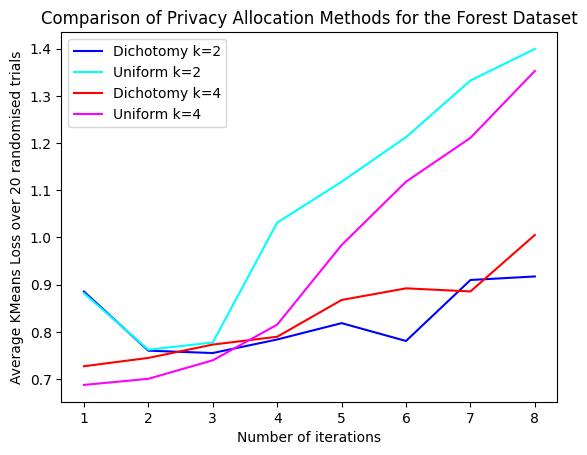

In [23]:
plt.plot(iterations, dichotomy, c="blue")
plt.plot(iterations, uniform, c="cyan")
plt.plot(iterations, dichotomy_k4, c="red")
plt.plot(iterations, uniform_k4, c= "magenta")
plt.title("Comparison of Privacy Allocation Methods for the Forest Dataset")
plt.xlabel("Number of iterations")
plt.ylabel("Average KMeans Loss over 20 randomised trials")
plt.legend(["Dichotomy k=2", "Uniform k=2", "Dichotomy k=4", "Uniform k=4"])